## `5_taichi.ipynb`

In [1]:
import copy
import os
# Remove warning when importing Taichi due to old glibc
os.environ["TI_MANYLINUX2014_OK"] = "1"
import taichi as ti
import numpy as np
from IPython.display import Markdown as md

[Taichi] version 1.6.0, llvm 16.0.0git, commit f1c6fbbd, linux, python 3.9.4


[I 08/27/23 23:24:28.588 898] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [ ]:
from common import initialize_field, plot_field, save_result, compare_results, read_results

In [ ]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

In [ ]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


## Pointwise Stencil

In [7]:
@ti.kernel
def taichi_ndarray_equal_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for k in range(NZ):
        for j in range(NY):
            for i in range(NX):
                out_field[k, j, i] = in_field[k, j, i]
                # taichi doesn't support an ndarray output, so there's no return value

def taichi_ndarray_pointwise(in_field, out_field): # There's no easy copying for ndarray, so we do that outside kernel
    for n in range(N_ITER):
        taichi_ndarray_equal_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

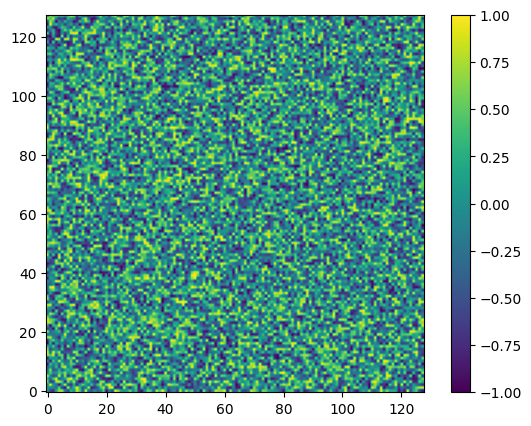

In [8]:
in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ))
out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_ndarray_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [7]:
%%timeit -o in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_ndarray_pointwise(in_field, out_field)

9.28 s ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 9.28 s ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [8]:
@ti.kernel
def taichi_ndarray_equal_more_parallel_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for k, j, i in ti.ndrange(NZ, NY, NX): # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_ndarray_more_parallel_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_ndarray_equal_more_parallel_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field.copy_from(out_field)

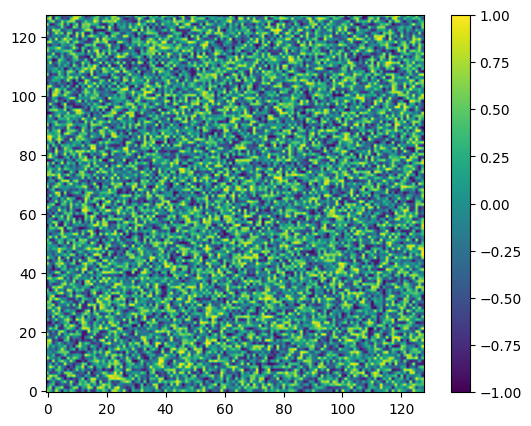

In [9]:
in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ))
out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_ndarray_more_parallel_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [10]:
%%timeit -o in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_ndarray_more_parallel_pointwise(in_field, out_field)

114 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 114 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [11]:
@ti.kernel
def taichi_ndarray_equal_more_parallel_XYZ_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for i, j, k in ti.ndrange(NX, NY, NZ): # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_ndarray_equal_more_parallel_XYZ_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field.copy_from(out_field)

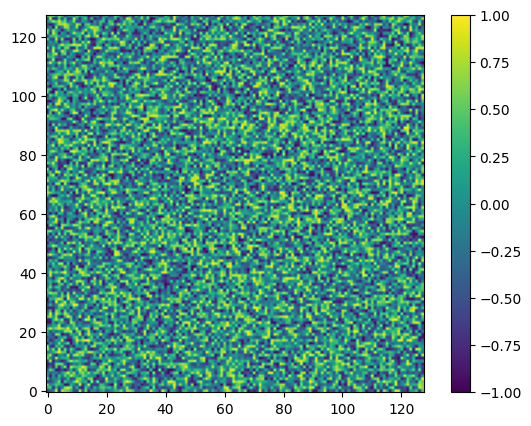

In [12]:
in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ))
out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [13]:
%%timeit -o in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field)

199 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 199 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [14]:
@ti.kernel
def taichi_field_equal_more_parallel_pointwise():
    for k, j, i in ti.ndrange(NZ, NY, NX): # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_field_more_parallel_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_equal_more_parallel_pointwise()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)

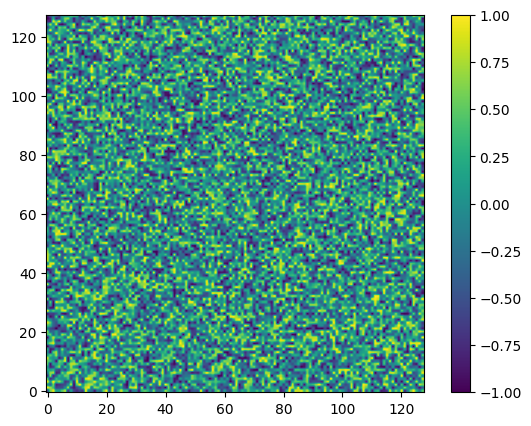

In [15]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [16]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_pointwise(in_field, out_field)

63.9 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 63.9 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [19]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


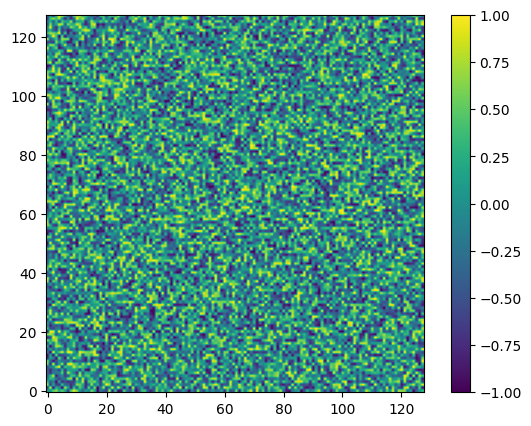

In [27]:
in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ))
out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_ndarray_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [28]:
%%timeit -o in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_ndarray_pointwise(in_field, out_field)

202 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 202 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

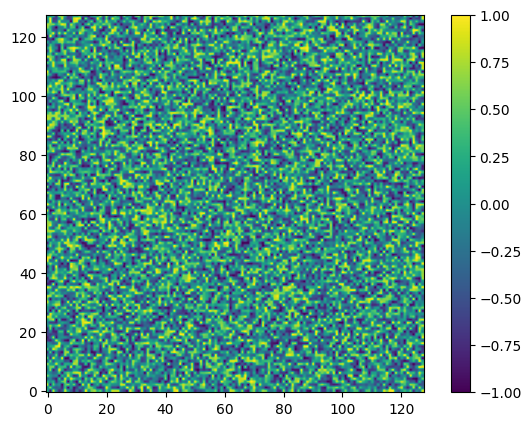

In [25]:
in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ))
out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_ndarray_more_parallel_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [26]:
%%timeit -o in_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.ndarray(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_ndarray_more_parallel_pointwise(in_field, out_field)

17.3 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 17.3 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

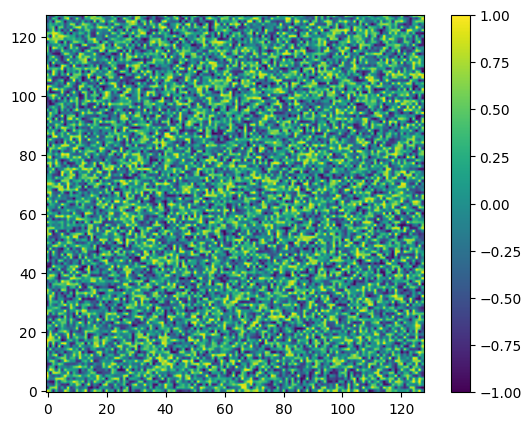

In [29]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [30]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_pointwise(in_field, out_field)

23.8 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 23.8 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [14]:
@ti.kernel
def taichi_field_equal_more_parallel_vector_x_pointwise():
    for k, j, i in ti.ndrange(NZ, NY, NX): # Will be parallelized
        out_field[k, j][i] = in_field[k, j][i]

def taichi_field_more_parallel_vector_x_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_equal_more_parallel_vector_x_pointwise()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)

In [47]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [48]:
@ti.kernel
def taichi_field_equal_more_parallel_sin_pointwise():
    for k, j, i in ti.ndrange(NZ, NY, NX):
        out_field[k, j, i] = ti.sin(in_field[k, j, i])

def taichi_field_more_parallel_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_equal_more_parallel_sin_pointwise()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)

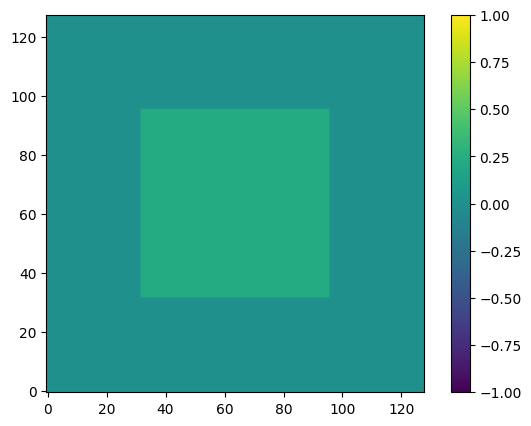

In [49]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_sin_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [50]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_sin_pointwise(in_field, out_field)

74.9 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 74.9 ms ± 802 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [51]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


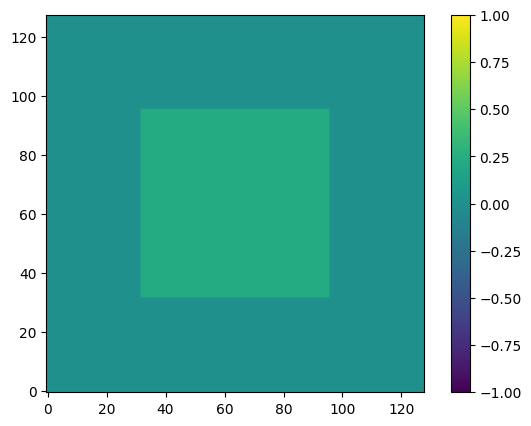

In [52]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_sin_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [53]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_sin_pointwise(in_field, out_field)

15.4 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 15.4 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

## 1D Stencil

### Same Column

In [13]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [22]:
@ti.kernel
def taichi_field_diff_1D_same_col():
    for k, j in ti.ndrange(NZ, NY):
        for i in range(NX-1):
            out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
        out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])

def taichi_field_1D_same_col(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_diff_1D_same_col()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)

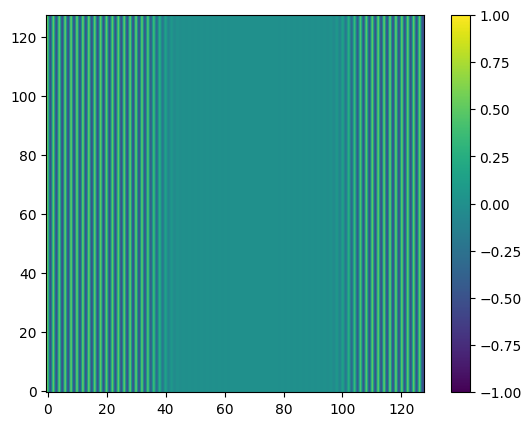

In [23]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="vertical-bars"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [24]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_1D_same_col(in_field, out_field)

63.8 ms ± 629 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 63.8 ms ± 629 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>